In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import itertools
#from scipy.optimize import curve_fit
#import neal
#from dwave.system import LeapHybridSampler


In [2]:
df_pre = pd.read_csv("data/formatted_medical7_raw_clean2.csv",header=0, sep="\,")
#df_post = pd.read_csv("data/formatted_medical5.csv",header=0, sep="\;")
#print(len(df_pre.columns))
#print(len(df_post.columns))
features_to_fill = [n for n, t in zip(df_pre.columns, df_pre.dtypes) if t == np.object_]

<ipython-input-2-98f4ff26866f>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_pre = pd.read_csv("data/formatted_medical7_raw_clean2.csv",header=0, sep="\,")


In [13]:
def get_convertion_map(frame):    
    """ Create convertion dictionary: str -> Int """
    if frame.dtype == np.object_:
        frame = frame.apply(lambda x : str(x))
    ma = {}
    se = np.unique(frame.values)
    
    for i in range(len(se)):
        ma[se[i]] = i
    
    key_set = list(ma.keys())
    if key_set[-1]!="nan":
        return ma
    else:
        res = {}
        key_set = list(set(key_set) - set([key_set[-1]]))
        for k in key_set:
            res[k] = ma[k]
        return res
        

def fillnan_with_dist(data):
    """ Fill nan values according to values distribution """
    
    dist = data.value_counts().to_dict()

    norm = sum(dist.values())
    for k, _ in dist.items():
        dist[k] /= norm

    keys = list(dist.keys())
    prob_keys = list(dist.values())
    conv_dict = get_convertion_map(data)

    col_type = (bool if len(keys) == 2 else str) if data.dtype == np.object_ else data.dtype
    #if data.dtypes == np.float64 or data.dtypes == np.int64:
    data = data.apply(lambda x : np.random.choice(keys, p = prob_keys) if pd.isnull(x) else x)
        
    #print(prob_keys)
    keys_list = list(conv_dict.keys())
    if col_type == str or data.dtype == np.object_:
        #index = np.random.choice(keys_list, p = prob_keys)
        data = data.apply(lambda x: conv_dict[x])
        #data = data.apply(lambda x:  conv_dict[] if pd.isnull(x) else x)
        if len(conv_dict) ==2 :
            data = data.astype(np.bool)
        
        return data
    
    return data.astype(col_type)

def clean_data(dataset, features_to_interpolation=[]):
    """ Preprocess data: fill nan and drop columns with fewer than 50% of recrods """
    if features_to_interpolation == []:
        features = list(dataset.columns)
    else:
        features = features_to_interpolation
        
    for ci in features:
            # drop column if more than 50% records are NaN
        if dataset[ci].isnull().sum()/len(dataset)>0.5:
            dataset.drop([ci], axis = 1, inplace=True)
            continue

        # fill missing values according to the values distribution 
        dataset[ci] = fillnan_with_dist(dataset[ci])
        
    return dataset

In [18]:
df_pre = pd.read_csv("data/formatted_medical7_raw_clean2.csv",header=0, sep="\,")
#features_to_fill = [n for n, t in zip(df_pre.columns, df_pre.dtypes) if t == np.object_]

df_post = clean_data(df_pre, ['CKD Cause',
 'Resistance mechanism',
 'Thrombocytopenia (PLT <150 tys/ul)',
 'Diuresis (Anuria / Oliguria/ Normal)',
 'AGR in the past'])

<ipython-input-18-6a9feee52b5d>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_pre = pd.read_csv("data/formatted_medical7_raw_clean2.csv",header=0, sep="\,")


In [22]:
df_post.to_csv("data/formatted_medical7_raw_clean3.csv", sep = ",")

In [20]:
df_post[['CKD Cause',
 'Resistance mechanism',
 'Thrombocytopenia (PLT <150 tys/ul)',
 'Diuresis (Anuria / Oliguria/ Normal)',
 'AGR in the past']]

,CKD Cause,Resistance mechanism,Thrombocytopenia (PLT <150 tys/ul),Diuresis (Anuria / Oliguria/ Normal),AGR in the past
0,14,0,4,2,0
1,6,6,2,2,0
2,3,6,4,2,0
3,7,6,4,2,0
4,8,6,4,2,0
...,...,...,...,...,...
296,7,0,0,0,0
297,7,0,0,0,0
298,3,0,0,0,0
299,7,0,0,0,0


In [69]:
def prob(dataset, max_bins=10):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins =[]
    bins = [min(len(np.unique(dataset[:, ci])), max_bins) for ci in range(num_columns)]
    freq, _ = np.histogramdd(dataset, bins)
    p = freq / np.sum(freq)
    return p

def shannon_entropy(p):
    """Shannon entropy H(X) is the sum of P(X)log(P(X)) for probabilty distribution P(X)."""
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)

def conditional_shannon_entropy(p, *conditional_indices):
    """Shannon entropy of P(X) conditional on variable j"""

    axis = tuple(i for i in np.arange(len(p.shape)) if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))


#print("H(in1) = {:.2f}".format(shannon_entropy(prob(toy[["in1"]].values))))
#print("H(in1|in3) = {:.2f}".format(conditional_shannon_entropy(prob(toy[["in1", "in3"]].values), 1)))
#print("H(in1|in2) = {:.2f}".format(conditional_shannon_entropy(prob(toy[["in1", "in2"]].values), 1)))

def mutual_information(p, j):
    """Mutual information between all variables and variable j"""
    return shannon_entropy(np.sum(p, axis=j)) - conditional_shannon_entropy(p, j)

def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z."""
    
    return conditional_shannon_entropy(np.sum(p, axis=j), *conditional_indices) - conditional_shannon_entropy(p, j, *conditional_indices)


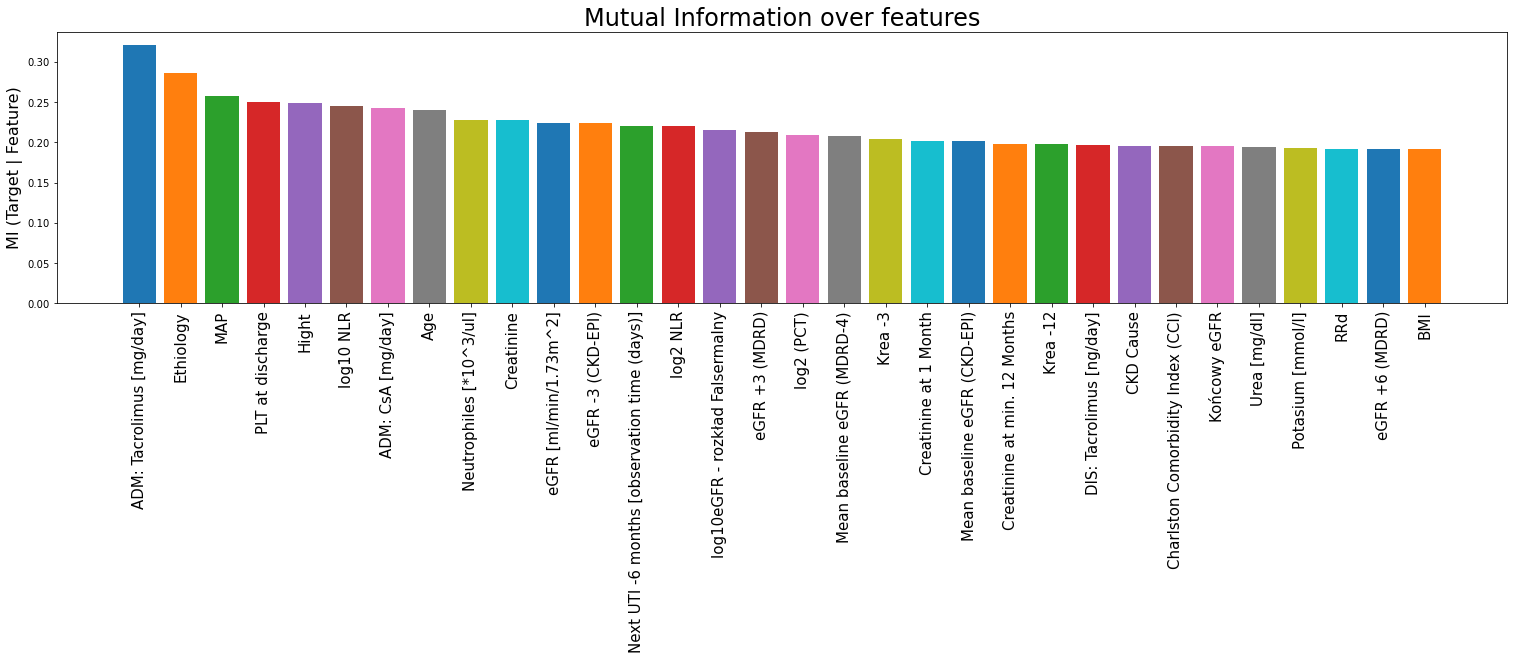

In [32]:
mi = {}
#target ="Graft loss 1 year"
target = "eGFR -12 (CKD-EPI)"
features = list(set(dfc.columns).difference((target,)))

for feature in features: 
    mi[feature] = mutual_information(prob(dfc[[target, feature]].values,10),1)

fig= plt.figure(figsize=(26,5))

for k, v in sorted(mi.items(), key = lambda x : x[1], reverse = True)[:32]:
    plt.bar(k, v)

plt.ylabel("MI (Target | Feature)", size = 16)
plt.title("Mutual Information over features", size = 24)
plt.xticks(rotation = 90, fontsize = 15)

plt.show()

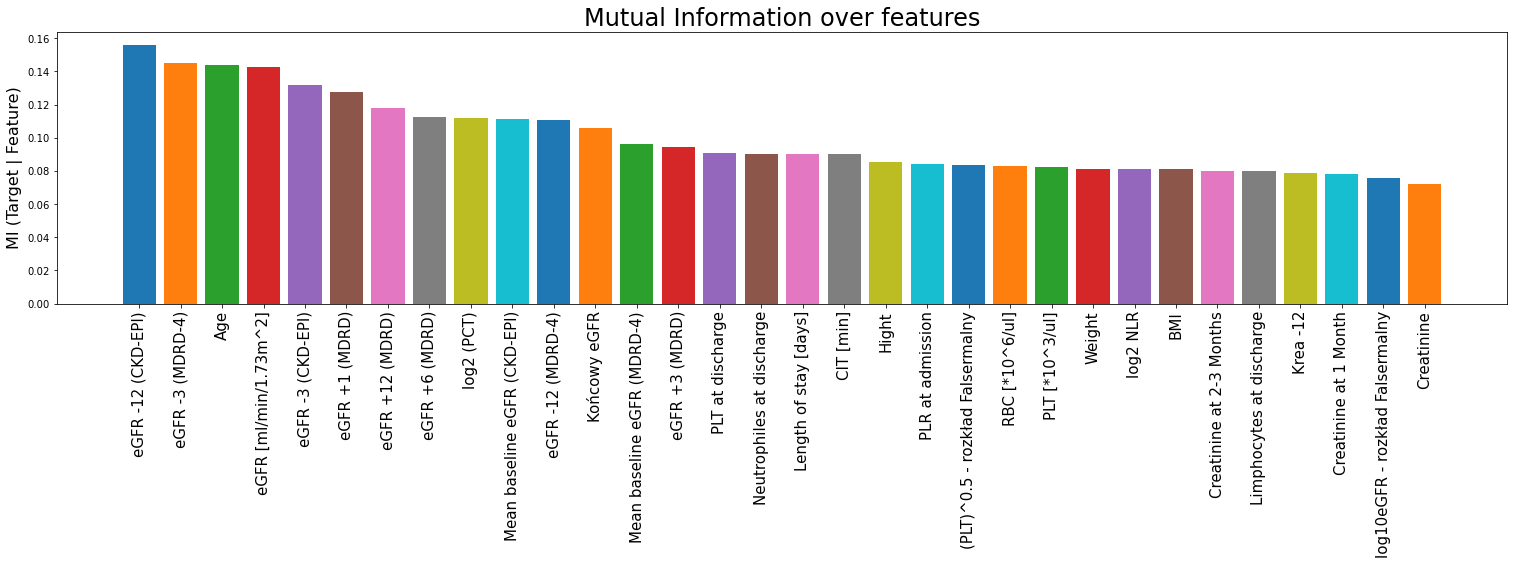

In [13]:
mi = {}
target ="Graft loss 1 year"
features = list(set(dfc.columns).difference((target,)))

for feature in features: 
    mi[feature] = mutual_information(prob(dfc[[target, feature]].values,50),1)

fig= plt.figure(figsize=(26,5))

for k, v in sorted(mi.items(), key = lambda x : x[1], reverse = True)[:32]:
    plt.bar(k, v)

plt.ylabel("MI (Target | Feature)", size = 16)
plt.title("Mutual Information over features", size = 24)
plt.xticks(rotation = 90, fontsize = 15)

plt.show()

In [ ]:
def get_convertion_map(frame):    
    """ Create convertion dictionary: str -> Int """
    if frame.dtype == np.object_:
        frame = frame.apply(lambda x : str(x))
    ma = {}
    se = np.unique(frame.values)
    
    for i in range(len(se)):
        ma[se[i]] = i
    
    key_set = list(ma.keys())
    if key_set[-1]!="nan":
        return ma
    else:
        res = {}
        key_set = list(set(key_set) - set([key_set[-1]]))
        for k in key_set:
            res[k] = ma[k]
        return res
        

def fillnan_with_dist(data):
    """ Fill nan values according to values distribution """
    
    dist = data.value_counts().to_dict()

    norm = sum(dist.values())
    for k, _ in dist.items():
        dist[k] /= norm

    keys = list(dist.keys())
    prob_keys = list(dist.values())
    conv_dict = get_convertion_map(data)

    col_type = (bool if len(keys) == 2 else str) if data.dtype == np.object_ else data.dtype
    if data.dtypes == np.float64 or data.dtypes == np.int64:
        data = data.apply(lambda x : np.random.choice(keys, p = prob_keys) if pd.isnull(x) else x)
        
    #print(prob_keys)
    keys_list = list(conv_dict.keys())
    if col_type == str or data.dtype == np.object_:
        index = np.random.choice(keys_list, p = prob_keys)
        data = data.apply(lambda x: conv_dict[index] if pd.isnull(x) else x)
        #data = data.apply(lambda x:  conv_dict[] if pd.isnull(x) else x)
        if len(conv_dict) ==2 :
            data = data.astype(np.bool)
        
        return data
    
    return data.astype(col_type)

def clean_data(dataset, features_to_interpolation=[]):
    """ Preprocess data: fill nan and drop columns with fewer than 50% of recrods """
    features = list(dataset.columns)
    
    for ci in features:
            # drop column if more than 50% records are NaN
        if dataset[ci].isnull().sum()/len(dataset)>0.5:
            dataset.drop([ci], axis = 1, inplace=True)
            continue

        # fill missing values according to the values distribution 
        dataset[ci] = fillnan_with_dist(dataset[ci])
        
    return dataset